In [57]:
import requests
import pandas as pd
import json

from urllib.parse import urlencode
from urllib.request import Request, urlopen

import re

pd.set_option('display.max_colwidth', 200)

In [58]:
consumer_key = "my_pocket_consumer_key"

In [59]:
# POST request for token
url = 'https://getpocket.com/v3/oauth/request' # Set destination URL here
post_fields = {"consumer_key": consumer_key, "redirect_uri":"https://www.google.com"}   # Set POST fields here
request = Request(url, urlencode(post_fields).encode())
json_request = urlopen(request).read().decode()

In [60]:
request_token = re.search('(?<=\=).*', json_request).group()

In [61]:
enter_in_browser = 'https://getpocket.com/auth/authorize?request_token=' + request_token + '&redirect_uri=https://www.google.com'

In [64]:
# POST request an access token
url = 'https://getpocket.com/v3/oauth/authorize' # Set destination URL here
post_fields = {"consumer_key": consumer_key, "code": request_token}  # Set POST fields here
request = Request(url, urlencode(post_fields).encode())
access_token = urlopen(request).read().decode()

In [65]:
access_token = re.search('(?<=\=)(.*?)(?=\&)', access_token).group()

## Get No articles

In [10]:
# GET request for data in JSON format
no_parameters = {"consumer_key":consumer_key, "access_token": access_token, "tag": 'n'}
no_response = requests.get("https://getpocket.com/v3/get", params=no_parameters)

In [11]:
no_response

<Response [200]>

In [12]:
no_df = pd.DataFrame(no_response.json()['list']).T
no_df['wanted'] = 'n'

no_df = no_df[['given_url', 'wanted']].copy().rename({'given_url': 'url'}, axis = 1)

In [13]:
no_df.head()

,url,wanted
3476401352,https://www.huffpost.com/entry/exposed-to-covid-at-work-what-to-ask-be-told_l_6184021de4b087e2ef945137,n
3476810938,https://www.huffpost.com/entry/best-friends-cheating-husband-stakeout_n_618546a5e4b087e2ef96abb4,n
3477048541,https://www.huffpost.com/entry/lance-bass-britney-spears-ancestry-test_n_618a7d4ae4b0a518aca60803,n
3477046417,https://www.huffpost.com/entry/drake-breaks-silence-on-astroworld-tragedy_n_618aaa21e4b0c8666be2eb2b,n
3476793988,https://www.huffpost.com/entry/alec-baldwin-police-weapons-safety_n_618a61dfe4b055e47d7fe7b0,n


## Get Yes articles

In [14]:
# GET request for data in JSON format
yes_parameters = {"consumer_key":consumer_key, "access_token": access_token, "tag": 'y'}
yes_response = requests.get("https://getpocket.com/v3/get", params=yes_parameters)

In [15]:
yes_response

<Response [200]>

In [16]:
yes_df = pd.DataFrame(yes_response.json()['list']).T
yes_df['wanted'] = 'y'

yes_df = yes_df[['given_url', 'wanted']].copy().rename({'given_url': 'url'}, axis = 1)

In [17]:
yes_df.head()

,url,wanted
3476754648,https://www.huffpost.com/entry/nikola-jokic-cheap-shot-markieff-morris_n_618a4882e4b06de3eb7a60a7,y
3476744814,https://www.huffpost.com/entry/thanksgiving-shortcuts_l_6183ef01e4b0ad6f587fb6d9,y
3476512361,https://www.huffpost.com/entry/jimmy-kimmel-aaron-rodgers-covid-vaccination_n_6189f3f8e4b087e2ef9bfec1,y
3476988454,https://www.huffpost.com/entry/judge-permits-unpaid-leave-unvaccinated-united-employees_n_618a98b2e4b0c8666be2b6cb,y
3476273279,https://www.huffpost.com/entry/democrats-tax-cuts-jobs-act_n_618982f1e4b0ad6f58872a10,y


In [18]:
full_df = pd.concat([yes_df, no_df]).reset_index(drop=True)

In [19]:
full_df.groupby('wanted').count()

,url
wanted,
n,69
y,96


In [20]:
full_df

,url,wanted
0,https://www.huffpost.com/entry/nikola-jokic-cheap-shot-markieff-morris_n_618a4882e4b06de3eb7a60a7,y
1,https://www.huffpost.com/entry/thanksgiving-shortcuts_l_6183ef01e4b0ad6f587fb6d9,y
2,https://www.huffpost.com/entry/jimmy-kimmel-aaron-rodgers-covid-vaccination_n_6189f3f8e4b087e2ef9bfec1,y
3,https://www.huffpost.com/entry/judge-permits-unpaid-leave-unvaccinated-united-employees_n_618a98b2e4b0c8666be2b6cb,y
4,https://www.huffpost.com/entry/democrats-tax-cuts-jobs-act_n_618982f1e4b0ad6f58872a10,y
...,...,...
160,https://www.elle.com/beauty/a38182879/ariana-grande-rem-beauty-interview/,n
161,https://www.elle.com/beauty/makeup-skin-care/g12505954/best-pore-minimizers/,n
162,https://www.elle.com/fashion/a38175883/kim-kardashian-fendi-x-skims-video-campaign/,n
163,https://www.menshealth.com/technology-gear/g29503936/hiking-essentials/,n


## Get article text

In [21]:
from bs4 import BeautifulSoup
from joblib import Parallel, delayed
import time

In [22]:
def get_article_text(url):
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    
    return " ".join(x.get_text() for x in soup.find_all('p'))
    

In [23]:
t = time.time()
article_texts = Parallel(n_jobs=-1)(delayed(get_article_text)(url) for url in full_df.loc[:, 'url'])
print(time.time() - t) 

40.16879892349243


In [24]:
len(article_texts)

165

In [25]:
full_df['article_text'] = article_texts

# turn text to lowercase
full_df['article_text'] = full_df['article_text'].str.lower() 

In [26]:
def clean_str(s):
    s = re.sub(r"\'s", " is", s) # replace 's with is
    s = re.sub(r"\'ve", " have", s) #replace 've with have
    s = re.sub(r"n\'t", " not", s) #replace 've with not
    s = re.sub(r"\'ll", " will", s) #replace 'll with will
    s = re.sub(r"http\S+", ' ', s) # replace urls with blank space
    s = re.sub(r"[^a-z \-]", " ", s) # remove all characters that are not alpha
    s = re.sub(r"[\-]", " ", s) # replace hyphens to join words
    s = re.sub(r"\b[a-zA-Z]\b", " ", s) # remove any one letter words
    s = re.sub('\S*@\S*\s?', '', s) # remove emails
    s = re.sub('\s+', ' ', s) # remove newline characters
    s = re.sub(r"\s{2,}", " ", s) # replace any extra spaces with one space
    return s.strip()

In [27]:
full_df['article_text_clean'] = full_df['article_text'].apply(clean_str)

In [28]:
full_df

,url,wanted,article_text,article_text_clean
0,https://www.huffpost.com/entry/nikola-jokic-cheap-shot-markieff-morris_n_618a4882e4b06de3eb7a60a7,y,"general assignment reporter, huffpost reigning mvp nikola jokic of the denver nuggets blindsided the miami heat’s markieff morris with a hit from behind that jerked morris’ head back during their ...",general assignment reporter huffpost reigning mvp nikola jokic of the denver nuggets blindsided the miami heat markieff morris with hit from behind that jerked morris head back during their nba ga...
1,https://www.huffpost.com/entry/thanksgiving-shortcuts_l_6183ef01e4b0ad6f587fb6d9,y,"on assignment for huffpost there’s one thing that all chefs seem to agree on when it comes to cooking thanksgiving dinner: there’s always a lot to do, so finding ways to save time is just as impor...",on assignment for huffpost there one thing that all chefs seem to agree on when it comes to cooking thanksgiving dinner there always lot to do so finding ways to save time is just as important as ...
2,https://www.huffpost.com/entry/jimmy-kimmel-aaron-rodgers-covid-vaccination_n_6189f3f8e4b087e2ef9bfec1,y,"overnight editor, huffpost jimmy kimmel spent much of his monday night monologue tearing into green bay packers quarterback aaron rodgers, who evaded questions about his vaccine status and then ca...",overnight editor huffpost jimmy kimmel spent much of his monday night monologue tearing into green bay packers quarterback aaron rodgers who evaded questions about his vaccine status and then caug...
3,https://www.huffpost.com/entry/judge-permits-unpaid-leave-unvaccinated-united-employees_n_618a98b2e4b0c8666be2b6cb,y,"breaking news reporter, huffpost a federal judge has ruled that united airlines can place its unvaccinated employees on unpaid leave, even if those employees received religious or medical exemptio...",breaking news reporter huffpost federal judge has ruled that united airlines can place its unvaccinated employees on unpaid leave even if those employees received religious or medical exemptions f...
4,https://www.huffpost.com/entry/democrats-tax-cuts-jobs-act_n_618982f1e4b0ad6f58872a10,y,"senior reporter, huffpost politics reporter, huffpost washington — after republicans slashed tax rates in 2017, democrats won control of the house of representatives partly by promising to undo th...",senior reporter huffpost politics reporter huffpost washington after republicans slashed tax rates in democrats won control of the house of representatives partly by promising to undo the gop tax ...
...,...,...,...,...
160,https://www.elle.com/beauty/a38182879/ariana-grande-rem-beauty-interview/,n,\n\t\tevery item on this page was chosen by an elle editor. we may earn commission on some of the items you choose to buy.\n\n\t\t\t the singer swatched each product as jennifer coolidge—bend-and-...,every item on this page was chosen by an elle editor we may earn commission on some of the items you choose to buy the singer swatched each product as jennifer coolidge bend and snap not included ...
161,https://www.elle.com/beauty/makeup-skin-care/g12505954/best-pore-minimizers/,n,\n\t\tevery item on this page was chosen by an elle editor. we may earn commission on some of the items you choose to buy.\n\n\t\t\t from de-gunking pore strips to facials in a jar. if pore size ...,every item on this page was chosen by an elle editor we may earn commission on some of the items you choose to buy from de gunking pore strips to facials in jar if pore size is concern know that f...
162,https://www.elle.com/fashion/a38175883/kim-kardashian-fendi-x-skims-video-campaign/,n,"\n\t\tevery item on this page was chosen by an elle editor. we may earn commission on some of the items you choose to buy.\n\n\t\t\t see kim kardashian west pose in hot pink, exclusively on elle.c...",every item on this page was chosen by an elle editor we may earn commission on some of the items you choose to buy see kim kardashian west pose in hot pink exclusively o

## Lemmatize text

In [29]:
import spacy

In [30]:
nlp = spacy.load("en_core_web_sm")

In [31]:
t = time.time()
full_df['article_text_clean'] = full_df['article_text_clean'].apply(lambda x: " ".join(token.lemma_ for token in nlp(x)) )
print(time.time() - t) 

66.36220097541809


In [32]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Haseeb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [33]:
# remove stop words
full_df['article_text_clean'] = full_df['article_text_clean'].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))

## Train Test Split

In [34]:
from sklearn.model_selection import train_test_split

In [35]:
seed = 111

X_train, X_test, y_train, y_test = train_test_split(full_df[['article_text_clean']], full_df['wanted'], test_size=0.25, random_state=seed)

## Modelling

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [37]:
# instantiate the tfidf vectorizer
vect = TfidfVectorizer(ngram_range=(1,3), min_df=3)

In [38]:
# fit transform x train features
tv = vect.fit_transform(X_train['article_text_clean'])

In [39]:
vect.get_feature_names_out()

array(['aaron', 'abandon', 'abc', ..., 'zombie', 'zone', 'zoom'],
      dtype=object)

In [40]:
# instatniate support vector classifier
clf = LinearSVC()

In [41]:
# fit model on train data
model = clf.fit(tv, y_train)

In [42]:
# transform test data using vectorizer
tv_test = vect.transform(X_test['article_text_clean'])

In [43]:
# predict using test data
preds = model.predict(tv_test)

In [44]:
# print confusion matrix to check accuracy of predictions
cm = confusion_matrix(y_test, preds, labels=clf.classes_)
cm

array([[16,  6],
       [ 0, 20]], dtype=int64)

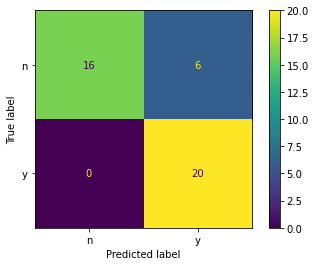

In [45]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.show()

## Import data from gsheet

In [46]:
import gspread

In [47]:
gc = gspread.oauth()

In [50]:
huffpost_sheet = gc.open_by_url('https://docs.google.com/spreadsheets/d/1pGmRPvw_5e4-m4oHhPGS9lQNLlMeVQS4ttv0uR9MRnI/edit#gid=0')
huffpost_url = pd.DataFrame(huffpost_sheet.sheet1.get_all_records() )['url']

In [51]:
espn_sheet = gc.open_by_url('https://docs.google.com/spreadsheets/d/1am1zgyfc0MDMjGd2ATm5DfJ5mm791Wcxv9SWKxWsKOo/edit#gid=0')
espn_url = pd.DataFrame(espn_sheet.sheet1.get_all_records() )['url']

In [52]:
buzzfeed_sheet = gc.open_by_url('https://docs.google.com/spreadsheets/d/14V9eGi-65vntZvGF5mIMBEB2j2mdFs723ixWAjjllQI/edit#gid=0')
buzzfeed_url = pd.DataFrame(buzzfeed_sheet.sheet1.get_all_records() )['url']

In [53]:
news_digest_urls = pd.concat([huffpost_url, espn_url, buzzfeed_url])

In [54]:
t = time.time()
news_digest_texts = Parallel(n_jobs=-1)(delayed(get_article_text)(url) for url in news_digest_urls)
print(time.time() - t) 

75.9353392124176


In [55]:
news_digest_df = pd.concat([news_digest_urls.reset_index(drop=True), pd.Series(news_digest_texts).reset_index(drop=True)], axis = 1)
news_digest_df.columns = ['url', 'article_text']

In [56]:
news_digest_df['article_text'] = news_digest_df['article_text'].str.lower() 
news_digest_df['article_text_clean'] = news_digest_df['article_text'].apply(clean_str)

t = time.time()
news_digest_df['article_text_clean'] = news_digest_df['article_text_clean'].apply(lambda x: " ".join(token.lemma_ for token in nlp(x)) )
print(time.time() - t) 

KeyboardInterrupt: 

In [ ]:
news_digest_df['article_text_clean'] = news_digest_df['article_text_clean'].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))

In [ ]:
test_matrix = vect.transform(news_digest_df['article_text_clean'])

In [ ]:
results = pd.DataFrame(model.predict(test_matrix), columns=['wanted'])

In [ ]:
import pickle

with open('svc_model.pkl', 'wb') as f:
    pickle.dump(model, f)
    
with open('tf_idf_vect.pkl', 'wb') as f:
    pickle.dump(vect, f)
    